## In this Jupyter notebook we demonstrate the results of our project

## 1. Import librairies and utils scripts

In [19]:
import sklearn.metrics
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from evaluation_utils import temporal_gt_pred_abnormal, temporal_gt_pred_normal, qualitative_test_normal, qualitative_test_abnormal, display_roc_curve, compute_false_alarm_normal, compute_false_alarm_abnormal
from Dataset import load_data
from Training_Model import network, train, display_loss_curve
from PreProcess_Videos import extract_all_features_normal, extract_all_features_abnormal

## 2. Features extraction with ResNet3D

Before run this scipt, you have to :

-In the script PreProcess_Videos.py, line 19, change the path where the pre-trained model ResNet3D-34 is located according your environnement.

-create a folder where the features will be saved

-change the path of the folders that match with you environnement 

-separate the files Anomaly_train.txt from the original dataset in 2 files: one for the abnormal videos (called Abnormal_Train.txt) and one for the normal videos (called Normal_Train.txt). Also for the test set you have to do the same things.



#### 2.1 Features extraction of the train set (UCF-Crime)

In [ ]:
parent_dir = '/Users/sofia/Desktop/Master_ISI/Machine learning&IA/Projet_MLA'

#where are stored the abnormal and normal videos
abnormal_videos_dir = parent_dir + '/Dataset' + '/train' +'/Abnormal'
normal_videos_dir = parent_dir + '/Dataset' + '/train' + '/Normal'

#Where the features will be saved
abnormal_features_dir = parent_dir + '/Features/train/Abnormal/'
normal_features_dir = parent_dir + '/Features/train/Normal/'

#files which contains the names of the videos using for the train set
train_abnormal_split = parent_dir + '/Dataset' + '/UCF_Crimes-Train-Test-Split' + '/Anomaly_Detection_splits' + '/Abnormal_Train.txt'
train_normal_split = parent_dir + '/Dataset' + '/UCF_Crimes-Train-Test-Split' + '/Anomaly_Detection_splits' + '/Normal_Train.txt'


#extract feature of all abnormal videos
extract_all_features_abnormal(train_abnormal_split, abnormal_videos_dir, abnormal_features_dir )

#extract feature of all abnormal videos
extract_all_features_normal(train_normal_split, normal_videos_dir, normal_features_dir)

#### 2.2 Features extraction of the test set (UCF-Crime)

In [ ]:
#where are stored the abnormal and normal videos
abnormal_videos_dir = parent_dir + '/Dataset' + '/test' +'/Abnormal'
normal_videos_dir = parent_dir + '/Dataset' + '/test' + '/Normal'

#Where the features will be saved
abnormal_features_dir = parent_dir + '/Features/test/Abnormal/'
normal_features_dir = parent_dir + '/Features/test/Normal/'

#files which contains the names of the videos using for the train set
test_abnormal_split = parent_dir + '/Dataset' + '/UCF_Crimes-Train-Test-Split' + '/Anomaly_Detection_splits' + '/Abnormal_Test.txt'
test_normal_split = parent_dir + '/Dataset' + '/UCF_Crimes-Train-Test-Split' + '/Anomaly_Detection_splits' + '/Normal_Test.txt'


#extract feature of all abnormal videos
extract_all_features_abnormal(test_abnormal_split, abnormal_videos_dir, abnormal_features_dir )

#extract feature of all abnormal videos
extract_all_features_normal(test_normal_split, normal_videos_dir, normal_features_dir)

## 3. Load the data (the extracted features)

In [20]:
#Folder where the project is located (videos .mp4 + features .txt + scipts .py)
parent_dir = '/Users/sofia/Desktop/Master_ISI/Machine learning&IA/Projet_MLA'
#parent_dir = '/content'

#Training DATA PATH
training_abnormal_features_path = parent_dir + '/Features' + '/train' +'/Abnormal'
training_normal_features_path = parent_dir + '/Features' + '/train' +'/Normal'

#Testing DATA PATH
testing_abnormal_features_path = parent_dir + '/Features' + '/test'+ '/Abnormal'
testing_normal_features_path = parent_dir + '/Features' + '/test'+ '/Normal'


#Load Training Data
print('Loading Training Data ...')
Abnormal_train, Normal_train, _, _ = load_data(abnormal_features_path = training_abnormal_features_path, normal_features_path = training_normal_features_path)

#Load Testing Data
print('Loading Testing Data ...')
Abnormal_test, Normal_test, abnormal_ignore_idx, normal_ignore_idx = load_data(abnormal_features_path = testing_abnormal_features_path, normal_features_path = testing_normal_features_path)

print('Data loaded ')

Loading Training Data ...
normal videos loading ...
Abnormal videos loading ...
Loading Testing Data ...
normal videos loading ...
Abnormal videos loading ...
Data loaded 


## 4. Training/Validation of the model

In [9]:
#hyper-parameters of the training
Batch_size = 60
num_iters = 20000

#create the anomaly detector
anomaly_detector = network()
anomaly_detector.summary()

#Run the training
training_loss, validation_loss = train(Batch_size, num_iters, anomaly_detector, Abnormal_train, Normal_train, Abnormal_test, Normal_test)

display_loss_curve(training_loss, validation_loss)


#Decomment if you want to save the weights of the model after the training

#Save the pre-trained model
#anomaly_detector.save_weights(parent_dir+'/checkpoint/my_checkpoint' ) 
#print('model saved at :', parent_dir+'/checkpoint/my_checkpoint' )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 69,825
Trainable params: 69,825
Non-trainable params: 0
_________________________________________________________________
iteration:  1 / 20000
loss train:  35.397617340087

KeyboardInterrupt: 

In [21]:
#Decomment if you want to load the pre-trained model and change the path of the file

#path_model = parent_dir+'/checkpoint/my_checkpoint'
#anomaly_detector.load_weights(path_model) 
#anomaly_detector.load_weights(path_model)
#print('loaded model from :', path_model )

loaded model from : /Users/sofia/Desktop/Master_ISI/Machine learning&IA/Projet_MLA/checkpoint/my_checkpoint


## 4. Evaluation of the model

#### Anomaly scores of the test set of UCF-Crime

In [22]:
#Prediction is an anomaly score [0,1] for each segment -> score 1x32 for one video
#Detector is good if score is higher for an Abnormal segment and lower for a Normal segment

#to store the scores for the abnormal and normal videos of the test set
abnormal_scores = np.zeros((len(Abnormal_test), 32))
normal_scores = np.zeros((len(Normal_test), 32))

#predicted scores of the abnormal videos of the test set
for i in range(len(Abnormal_test)):
    inputs = Abnormal_test[i]
    predictions = anomaly_detector.predict_on_batch(inputs)
    #one score per segment -> score: (32,)
    abnormal_scores[i,:] = predictions.reshape(32)

#predicted scores of the normal videos of the test set
for i in range(len(Normal_test)):
    inputs = Normal_test[i]
    predictions = anomaly_detector.predict_on_batch(inputs)
    #one score per segment -> score: (32,)
    normal_scores[i,:] = predictions.reshape(32)

#### Temporal Ground Truths and Temporal Predictions

In [23]:
#Temporal Ground Truths: one label (0:normal or 1:abnormal) for each frame of the video
#Temporal Predictions: one score [0,1] for each frame of the video. 
#High score -> detected anomaly, low score -> no detected anomaly
  
#Assume we have separate the temporal annotations in 2 files: abnormal and normal temporal annotations .txt

#Temporal annotation for Normal videos 
temporal_annotation_normal = parent_dir + '/Dataset' + '/' + 'temporal_annotation_normal_videos.txt'
normal_videos_dir = parent_dir + '/Dataset' + '/test' + '/Normal'

#Temporal annotation for Abnormal videos 
temporal_annotation_abnormal = parent_dir + '/Dataset' + '/' + 'temporal_annotation_abnormal_videos.txt'
abnormal_videos_dir = parent_dir + '/Dataset' + '/test' + '/Abnormal'


#Get Temporal Ground truths and Temporal Predictions of the Test Set (UCF-Crime dataset)
gts_abnormal, preds_abnormal = temporal_gt_pred_abnormal(temporal_annotation_abnormal, abnormal_videos_dir, abnormal_scores, abnormal_ignore_idx)
gts_normal, preds_normal = temporal_gt_pred_normal(temporal_annotation_normal, normal_videos_dir, normal_scores, normal_ignore_idx)

#Concatenate Ground Truths and Predictions of Abnormal and Normal
ground_truths_test = np.hstack((gts_abnormal,gts_normal))
predictions_test = np.hstack((preds_abnormal,preds_normal))

#### 4.1 ROC curve

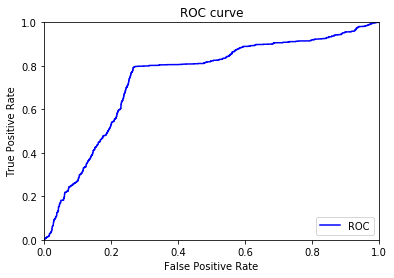

In [24]:
#Display ROC curve
fpr, tpr, thr = sklearn.metrics.roc_curve(ground_truths_test, predictions_test, pos_label=1)
display_roc_curve(fpr, tpr)

#### 4.2 AUC

In [25]:
#AuC
auc = sklearn.metrics.auc(fpr, tpr)
print('AuC : ', auc)

AuC :  0.7439778099522809


#### 4.3 Qualitative Evaluation: temporal anomaly detection on a test video

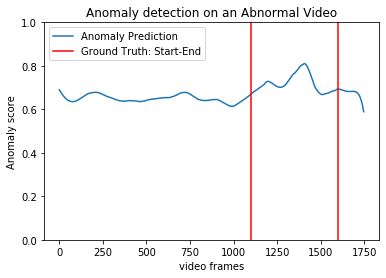

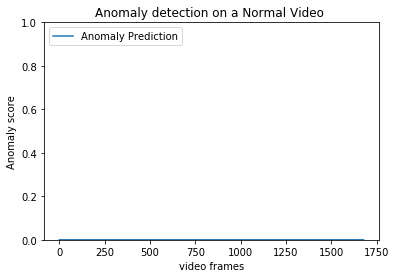

In [26]:
#it consists to display anomaly score for each frame of a test video


#Test on an Abnormal video: Explosion
video_name = 'Explosion008_x264'
video_path = parent_dir + '/Dataset' + '/test' + '/Abnormal' + '/Explosion' + '/'+ video_name +'.mp4'
features_path = parent_dir + '/Features' + '/test'+ '/Abnormal' + '/Explosion' + '/' + video_name + '.txt'

#Start and End frames of the Explosion
#we consider the temporal window as the original article, see figure 4.a)
anomaly_start_frame = 1100  
anomaly_end_frame = 1600

#display anomaly score for each frame
qualitative_test_abnormal(video_name, video_path, features_path, anomaly_start_frame, anomaly_end_frame, anomaly_detector)


#Test on a Normal video
video_name = 'Normal_Videos_033_x264'
video_path = parent_dir + '/Dataset' + '/test' + '/Normal' + '/'+ video_name +'.mp4'
features_path = parent_dir + '/Features' + '/test'+ '/Normal' + '/' + video_name + '.txt'

#display anomaly score for each frame
qualitative_test_normal(video_name, video_path, features_path, anomaly_detector)

#### 4.4 False Alarm Rate

In [27]:
#False Alarm Rate
threshold = 0.5

False_Alarm_Rate1 = compute_false_alarm_normal(gts_normal, preds_normal, threshold)
print('False Alarm Rate on Normal Videos Test: ', False_Alarm_Rate1)

False_Alarm_Rate2 = compute_false_alarm_abnormal(gts_abnormal, preds_abnormal, threshold)
print('False Alarm Rate on Abnormal Videos Test: ', False_Alarm_Rate2)

False Alarm Rate on Normal Videos Test:  1.580323081250731e-06
False Alarm Rate on Abnormal Videos Test:  1.0
